Import Library & Package

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

Data Understanding

In [55]:
# Memuat Dataset

file_path = "../dataset/data_balita.csv"
df = pd.read_csv(file_path)
df.head(10)

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted
5,0,laki-laki,44.257719,stunted
6,0,laki-laki,59.572523,tinggi
7,0,laki-laki,42.701796,severely stunted
8,0,laki-laki,45.251779,stunted
9,0,laki-laki,57.201961,tinggi


In [56]:
# Mengecek Jumlah Data dalam dataset

total = df.shape[0]
print(f"Jumlah data dalam dataset: {total}")

Jumlah data dalam dataset: 120999


In [57]:
# Mengecek Missing Value

df.isna().sum()

Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          0
dtype: int64

In [58]:
# Mengecek Outliers

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

numerical_columns = ["Umur (bulan)", "Tinggi Badan (cm)"]
outliers_iqr = {col: detect_outliers_iqr(df, col) for col in numerical_columns}
outlier_counts = {col: {"IQR": len(outliers_iqr[col])} for col in numerical_columns}

print("Jumlah outlier yang terdeteksi:")
for col, counts in outlier_counts.items():
    print(f"{col}: IQR = {counts['IQR']}")

Jumlah outlier yang terdeteksi:
Umur (bulan): IQR = 0
Tinggi Badan (cm): IQR = 38


In [59]:
# Mengecek Tipe Data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1976\252841777.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="colorblind")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1976\252841777.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = gender_percentages[i]


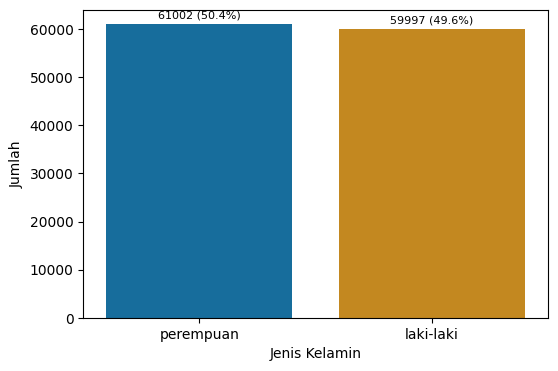

In [60]:
# Visualisasi Jumlah dan Persentase Jenis Kelamin

gender_counts = df["Jenis Kelamin"].value_counts()
total_data = len(df)
gender_percentages = (gender_counts / total_data) * 100

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="colorblind")

for i, v in enumerate(gender_counts.values):
    percentage = gender_percentages[i]
    offset = max(0.02 * v, 2)
    ax.text(i, v + offset, f"{v} ({percentage:.1f}%)", ha='center', fontsize=8)

plt.xlabel("Jenis Kelamin")
plt.ylabel("Jumlah")
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_1976\3146310614.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1976\3146310614.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = status_percentages[i]


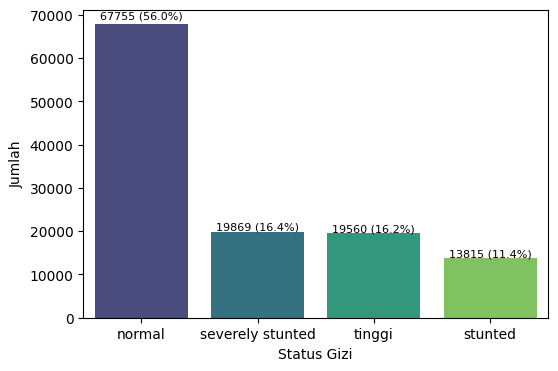

In [61]:
# Visualisasi jumlah Status Gizi

status_counts = df["Status Gizi"].value_counts()
total_data = len(df)
status_percentages = (status_counts / total_data) * 100

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")

for i, v in enumerate(status_counts.values):
    percentage = status_percentages[i]
    offset = max(0.02 * v, 1)
    ax.text(i, v + offset, f"{v} ({percentage:.1f}%)", ha='center', fontsize=8)

plt.xlabel("Status Gizi")
plt.ylabel("Jumlah")
plt.show()

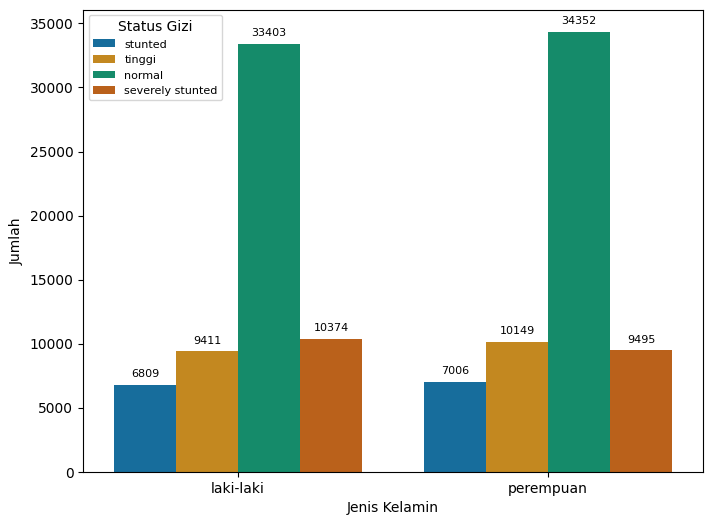

In [62]:
# Visualisasi Jumlah Status Gizi Berdasarkan Jenis Kelamin

gender_status_counts = df.groupby("Jenis Kelamin")["Status Gizi"].value_counts().unstack()
gender_totals = df["Jenis Kelamin"].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.countplot(x="Jenis Kelamin", hue="Status Gizi", data=df, palette="colorblind")

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            x_pos = bar.get_x() + bar.get_width() / 2 
            ax.text(x_pos, height + 0.01 * max(gender_totals), f"{int(height)}",
                    ha='center', fontsize=8, color='black')

plt.xlabel("Jenis Kelamin")
plt.ylabel("Jumlah")
plt.legend(title="Status Gizi", loc='upper left', fontsize=8)
plt.show()


Data Preparation

In [63]:
# Pembersihan Data - Menghapus Outliers

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

df_cleaned = df.copy()
for col in numerical_columns:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

print(f"Jumlah data setelah menghapus outlier: {len(df_cleaned)}")

Jumlah data setelah menghapus outlier: 120961


In [64]:
# Mengubah Jenis Kelamin dan Status Gizi Menjadi Numerik

label_encoders = {}
for col in ["Jenis Kelamin", "Status Gizi"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [67]:
# Simpan Label Encoders

joblib.dump(label_encoders, "../utils/label_encoders.pkl")
print("Label Encoders berhasil disimpan")

Label Encoders berhasil disimpan


In [68]:
df.head(10)

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,0,44.591973,2
1,0,0,56.705203,3
2,0,0,46.863358,0
3,0,0,47.508026,0
4,0,0,42.743494,1
5,0,0,44.257719,2
6,0,0,59.572523,3
7,0,0,42.701796,1
8,0,0,45.251779,2
9,0,0,57.201961,3


In [69]:
# Membagi Features and Target

X = df.drop("Status Gizi", axis=1)
y = df["Status Gizi"]

In [70]:
# Melakukan Oversampling

print("Distribusi sebelum SMOTE:", Counter(y))

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["Status Gizi"] = y_resampled

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["Status Gizi"] = y_resampled

print("Distribusi setelah SMOTE:", Counter(y_resampled))

Distribusi sebelum SMOTE: Counter({0: 67755, 1: 19869, 3: 19560, 2: 13815})
Distribusi setelah SMOTE: Counter({2: 67755, 3: 67755, 0: 67755, 1: 67755})


In [71]:
# Split dataset menjadi train dan test (80% training, 20% testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Modeling

In [72]:
# Inisialisasi Model

knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
svc_model = SVC(C=1.0, random_state=42)

In [73]:
# Training Model

y_pred_knn = knn_model.fit(X_train, y_train).predict(X_test)
y_pred_rf = rf_model.fit(X_train, y_train).predict(X_test)
y_pred_svc = svc_model.fit(X_train, y_train).predict(X_test)

Evaluasi model

In [74]:
# Evaluasi Model Accuracy

accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

print(f"Akurasi Model KNN: {accuracy_knn:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn, target_names=label_encoders["Status Gizi"].classes_))
print(f"Akurasi Model Random Forest: {accuracy_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=label_encoders["Status Gizi"].classes_))
print(f"Akurasi Model SVM: {accuracy_svc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svc, target_names=label_encoders["Status Gizi"].classes_))

Akurasi Model KNN: 0.9966

Classification Report:
                   precision    recall  f1-score   support

          normal       1.00      1.00      1.00     13382
severely stunted       0.99      1.00      1.00      4130
         stunted       0.99      0.99      0.99      2790
          tinggi       1.00      1.00      1.00      3898

        accuracy                           1.00     24200
       macro avg       1.00      1.00      1.00     24200
    weighted avg       1.00      1.00      1.00     24200

Akurasi Model Random Forest: 0.9946

Classification Report:
                   precision    recall  f1-score   support

          normal       0.99      1.00      1.00     13382
severely stunted       1.00      1.00      1.00      4130
         stunted       0.99      0.98      0.99      2790
          tinggi       1.00      0.99      0.99      3898

        accuracy                           0.99     24200
       macro avg       0.99      0.99      0.99     24200
    weighted 

Visualisasi ROC & AUC

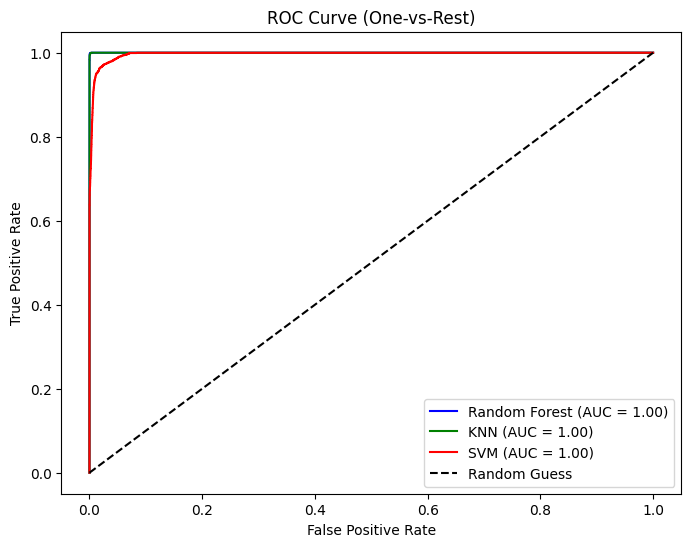

In [75]:
# Binarisasi label untuk multi-class ROC (One-vs-Rest)
n_classes = len(label_encoders["Status Gizi"].classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Prediksi probabilitas
y_score_rf = rf_model.predict_proba(X_test)
y_score_knn = knn_model.predict_proba(X_test)
y_score_svc = svc_model.decision_function(X_test)

# Menyimpan hasil ROC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

models = {'Random Forest': y_score_rf, 'KNN': y_score_knn, 'SVM': y_score_svc}

# Loop untuk setiap kelas
for model_name, y_score in models.items():
    fpr[model_name] = {}
    tpr[model_name] = {}
    roc_auc[model_name] = {}

    for i in range(n_classes):
        fpr[model_name][i], tpr[model_name][i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[model_name][i] = auc(fpr[model_name][i], tpr[model_name][i])

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red']
for model_name, color in zip(models.keys(), colors):
    plt.plot(fpr[model_name][1], tpr[model_name][1], color=color,
             label=f'{model_name} (AUC = {roc_auc[model_name][1]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()

Deployment

In [76]:
# Simpan Model

joblib.dump(svc_model, "../model/svm_model.pkl")
print("Model berhasil disimpan'")

Model berhasil disimpan'


In [80]:
loaded_model = joblib.load("../model/svm_model.pkl")
loaded_label_encoders = joblib.load("../utils/label_encoders.pkl")

In [81]:
while True:
    try:
        umur = int(input("Masukkan umur (bulan): "))
        jenis_kelamin = input("Masukkan jenis kelamin (L/P): ").strip().upper()
        tinggi_badan = float(input("Masukkan tinggi badan (cm): "))
        
        if jenis_kelamin == "L":
            jenis_kelamin = loaded_label_encoders["Jenis Kelamin"].transform(["laki-laki"])[0]
        elif jenis_kelamin == "P":
            jenis_kelamin = loaded_label_encoders["Jenis Kelamin"].transform(["perempuan"])[0]
        else:
            print("Jenis kelamin tidak valid. Gunakan 'L' atau 'P'.")
            continue
        
        input_data = pd.DataFrame([[umur, jenis_kelamin, tinggi_badan]], columns=["Umur (bulan)", "Jenis Kelamin", "Tinggi Badan (cm)"])
        prediksi = loaded_model.predict(input_data)[0]
        status_gizi = loaded_label_encoders["Status Gizi"].inverse_transform([prediksi])[0]
        
        print(f"Prediksi Status Gizi: {status_gizi}")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")
    
    ulang = input("Ingin menginput data lagi? (y/n): ").strip().lower()
    if ulang != 'y':
        break


Prediksi Status Gizi: severely stunted
